In [1]:
import argparse
from collections import OrderedDict
from typing import Dict, Tuple, List
from torch.utils.data import DataLoader

import torch

import flwr as fl
from flwr.common import Metrics, ndarrays_to_parameters
from flwr.common.logger import configure
from flwr.common.typing import Scalar

from utils_mnist import (
    test,
    visualize_gen_image,
    visualize_gmm_latent_representation,
    non_iid_train_iid_test,
    alignment_dataloader,
    train_align,
)
from utils_mnist import VAE
import os
import numpy as np


/home/mayag88/mayag88/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-23 16:14:36,401	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def set_params(model: torch.nn.ModuleList, params: List[fl.common.NDArrays]):
    """Set model weights from a list of NumPy ndarrays."""
    params_dict = zip(model.state_dict().keys(), params)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VAE()
trainsets, valsets = non_iid_train_iid_test()
testset = valsets[-1]
model.to(device)

testloader = DataLoader(testset, batch_size=64)

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def visualize_gmm_latent_representation(
    model, test_loader, device
):
    model.eval()
    all_latents = []
    all_labels = []
    all_means = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            z, mu, _ = model(data)
            all_latents.append(z.cpu().numpy())
            all_means.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())

    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_means = np.concatenate(all_means, axis=0)
    # Assuming all_latents is your high-dimensional data


    tsne = TSNE(n_components=2, random_state=42)
    reduced_latents = tsne.fit_transform(all_latents)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # t-SNE Scatter Plot
    scatter1 = axs[0].scatter(
        reduced_latents[:, 0],
        reduced_latents[:, 1],
        s=2,
        c=all_labels,
        cmap="tab10",
        label="Labels",
        alpha=0.9,
        zorder=2,
    )
    axs[0].legend()
    axs[0].set_title("t-SNE Latent Representation")

    # Original Scatter Plot
    scatter2 = axs[1].scatter(
        all_means[:, 0],
        all_means[:, 1],
        s=2,
        c=all_labels,
        cmap="tab10",
        label="Labels",
        alpha=0.9,
        zorder=2,
    )
    axs[1].legend()
    axs[1].set_title("Original Latent Representation")
    plt.colorbar(scatter1, ax=axs, label="Digit Label")


    plt.show()

In [9]:
def latent_stats(model, test_loader, device):
    model.eval()
    all_latents = []
    all_labels = []
    all_means = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            z, mu, _ = model(data)
            all_latents.append(z.cpu().numpy())
            all_means.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())

    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_means = np.concatenate(all_means, axis=0)
    return all_latents,all_means,all_labels


    

In [5]:
with open(f"sim_prox_gmm10/weights_prox_round_0.npy", "rb") as f:
    parameters_prox_0=np.load(f,allow_pickle=True)
with open(f"sim_prox_gmm10/weights_prox_round_10.npy", "rb") as f:
    parameters_prox_10=np.load(f,allow_pickle=True)
with open(f"sim_cir_gmm10/weights_cir_round_0.npy", "rb") as f:
    parameters_cir_0=np.load(f,allow_pickle=True)
with open(f"sim_cir_gmm10/weights_cir_round_10.npy", "rb") as f:
    parameters_cir_10=np.load(f,allow_pickle=True)
with open(f"sim_avg_gmm10/weights_avg_round_0.npy", "rb") as f:
    parameters_avg_0=np.load(f,allow_pickle=True)
with open(f"sim_avg_gmm10/weights_avg_round_10.npy", "rb") as f:
    parameters_avg_10=np.load(f,allow_pickle=True)
with open(f"sim_cir_reg_10/weights_cir_round_0.npy", "rb") as f:
    parameters_cir_reg_0=np.load(f,allow_pickle=True)
with open(f"sim_cir_reg_10/weights_cir_round_10.npy", "rb") as f:
    parameters_cir_reg_10=np.load(f,allow_pickle=True)



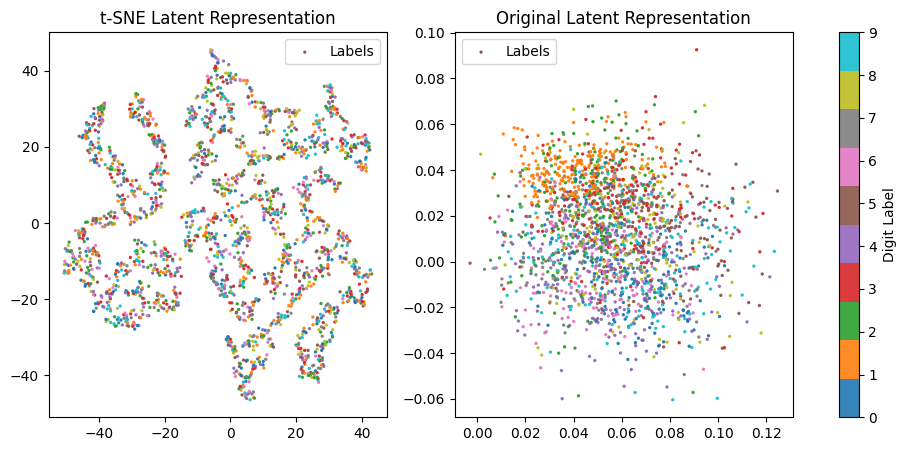

In [6]:
set_params(model, parameters_prox_0.tolist())
visualize_gmm_latent_representation(model,testloader,device)

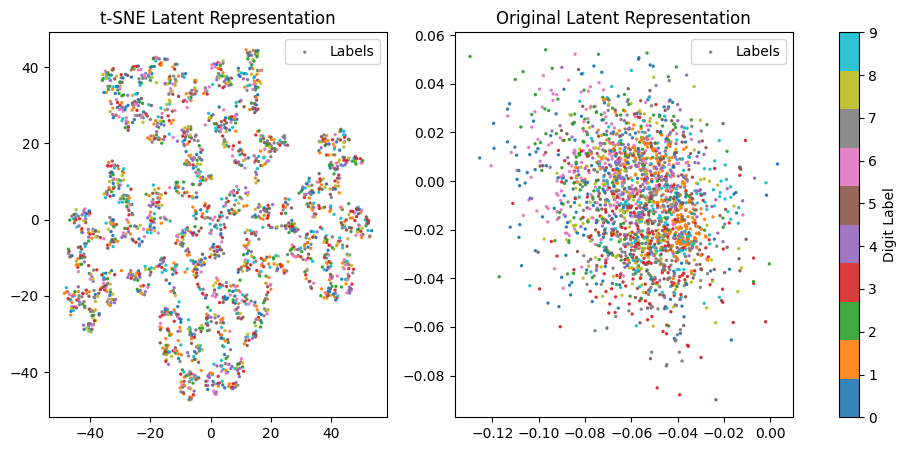

In [23]:
set_params(model, parameters_cir_0.tolist())
visualize_gmm_latent_representation(model, testloader, device)

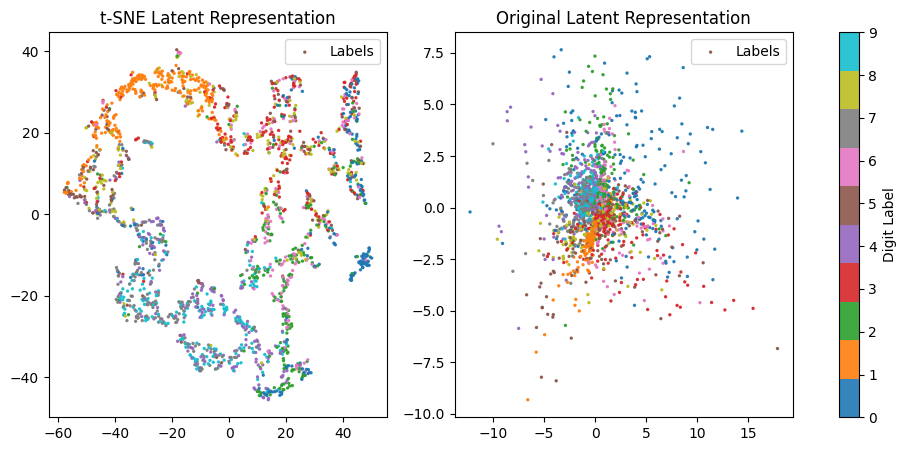

In [7]:
set_params(model, parameters_prox_10.tolist())
visualize_gmm_latent_representation(model, testloader, device)

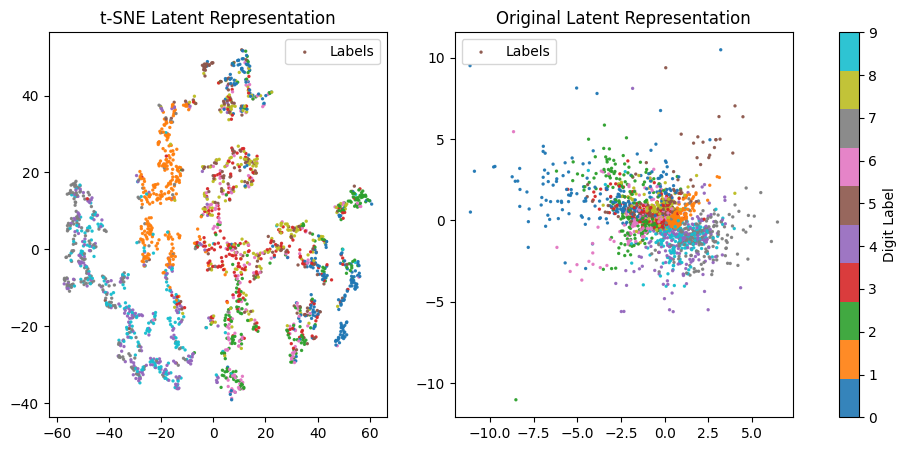

In [10]:
set_params(model, parameters_cir_10.tolist())
visualize_gmm_latent_representation(model, testloader, device)

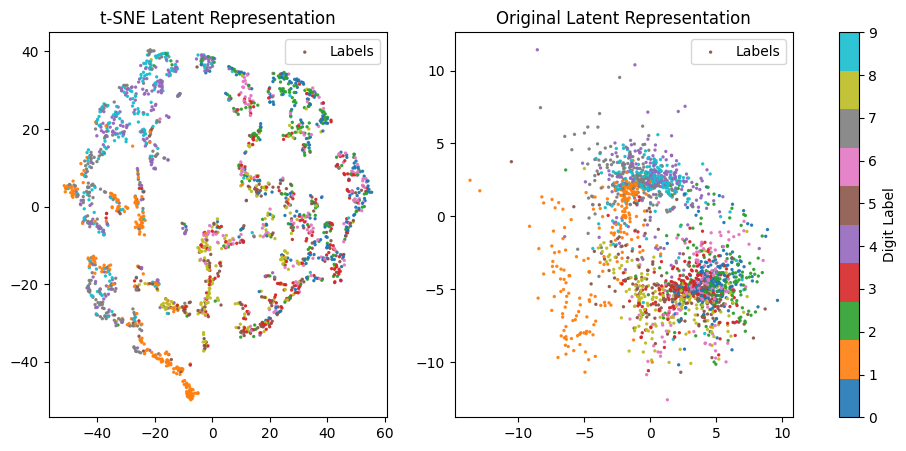

In [18]:
set_params(model, parameters_cir_reg_10.tolist())
visualize_gmm_latent_representation(model, testloader, device)

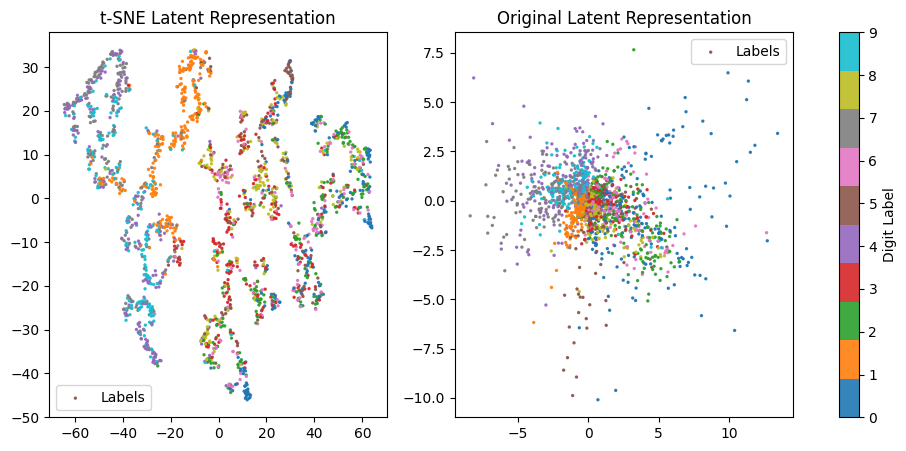

In [16]:
set_params(model, parameters_avg_10.tolist())
visualize_gmm_latent_representation(model, testloader, device)

{'NN classification on test data': 34.5,
 'Positive clustering at error rate 0.1%': 1.1390777144956825,
 'Positive clustering at error rate 1%': 5.22714520509854,
 'Positive clustering at error rate 10%': 24.612321305321487,
 'Trapz': 0.6282574340064464}


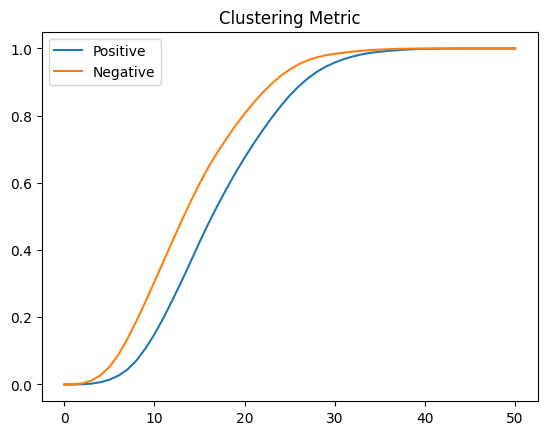

In [46]:
set_params(model, parameters_avg_10.tolist())
all_latents_avg_10, all_means_avg_10, all_labels_avg_10 = latent_stats(
    model, testloader, device
)
reid_evaluation(all_means_avg_10, all_labels_avg_10)

{'NN classification on test data': 36.2,
 'Positive clustering at error rate 0.1%': 0.7274406502773213,
 'Positive clustering at error rate 1%': 4.776280965882289,
 'Positive clustering at error rate 10%': 28.580224538335873,
 'Trapz': 0.7424653663406504}


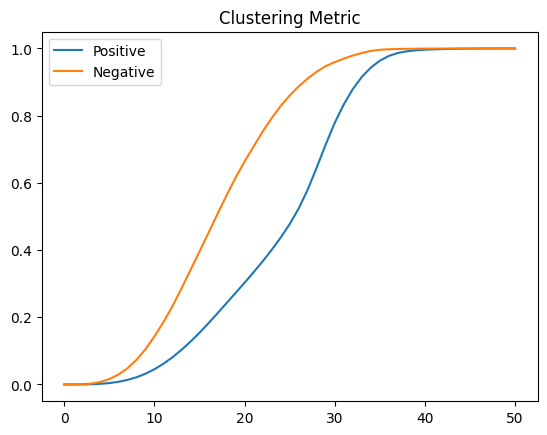

In [45]:
set_params(model, parameters_cir_reg_10.tolist())
all_latents_cir_reg_10, all_means_cir_reg_10, all_labels_cir_reg_10 = latent_stats(
    model, testloader, device
)
reid_evaluation(all_means_cir_reg_10, all_labels_cir_reg_10)

In [11]:
set_params(model, parameters_cir_10.tolist())
all_latents_cir_10, all_means_cir_10, all_labels_cir_10=latent_stats(model, testloader, device)

In [12]:
from scipy.spatial import distance_matrix
from pprint import pprint


def reid_evaluation(embeddings, labels):
    mat = distance_matrix(embeddings, embeddings)

    same_distances = []
    diff_distances = []

    dev_ind = [np.where(np.array(labels) == i)[0] for i in range(10)]
    for i in range(10):
        for j in range(i, 10):
            sub_mat = mat[dev_ind[i]].T
            subsub_mat = sub_mat[dev_ind[j]]
            for ind_i in range(len(subsub_mat)):
                for ind_j in range(ind_i + 1, len(subsub_mat[0])):
                    d = subsub_mat[ind_i][ind_j]
                    if i == j:
                        same_distances.append(d)
                    else:
                        diff_distances.append(d)

    roc_value = []
    th_steps = 50
    max_dist = max(diff_distances)
    min_dist = min(same_distances)

    for th in range(th_steps + 1):
        t = (th + 0.5) / th_steps
        t = t * t
        threshold = t * max_dist + (1 - t) * min_dist
        #         threshold = threshold * threshold
        ta = len(np.where(np.array(same_distances) < threshold)[0]) / len(
            same_distances
        )
        fa = len(np.where(np.array(diff_distances) < threshold)[0]) / len(
            diff_distances
        )
        roc_value.append([fa, ta, threshold])
    roc_value = np.array(roc_value)
    area = np.trapz(roc_value[:, 1], roc_value[:, 0])

    # Get accuracy when fa=0.1% , 1%, 10%
    targets_fa = [0.001, 0.01, 0.1]
    current_target_fa_id = 0
    target_th = []
    ta_accuracy = []
    for i in range(len(roc_value)):
        if roc_value[i][0] >= targets_fa[current_target_fa_id]:
            target_th.append(roc_value[i][2])
            ta_accuracy.append(roc_value[i][1])
            current_target_fa_id += 1
            if current_target_fa_id >= len(targets_fa):
                break

    # Nearest Neighbor accuracy
    correct_classification = 0
    wrong_classification = 0
    nearest10_amt = 0
    for i in range(len(mat)):
        nearest_id = np.argpartition(mat[i], 2)[1]
        nearest_10id = np.argpartition(mat[i], 11)[1:11]
        if labels[nearest_id] == labels[i]:
            correct_classification += 1
        else:
            wrong_classification += 1

        nearest10_amt += len(np.where(np.array(labels)[nearest_10id] == labels[i])[0])

    plt.plot(roc_value[:, 0], label="Positive")
    plt.plot(roc_value[:, 1], label="Negative")

    # Add title and legend
    plt.title("Clustering Metric")
    plt.legend(["Positive", "Negative"])

    # Show the plot
    pprint(
        {
            "Positive clustering at error rate 0.1%": 100 * ta_accuracy[0],
            "Positive clustering at error rate 1%": 100 * ta_accuracy[1],
            "Positive clustering at error rate 10%": 100 * ta_accuracy[2],
            "Trapz": area,
            "NN classification on test data": 100
            * correct_classification
            / (correct_classification + wrong_classification),
        }
    )
    plt.show()


{'NN classification on test data': 40.05,
 'Positive clustering at error rate 0.1%': 1.5139703363109573,
 'Positive clustering at error rate 1%': 7.307178573024614,
 'Positive clustering at error rate 10%': 30.53562473000283,
 'Trapz': 0.6546617144704674}


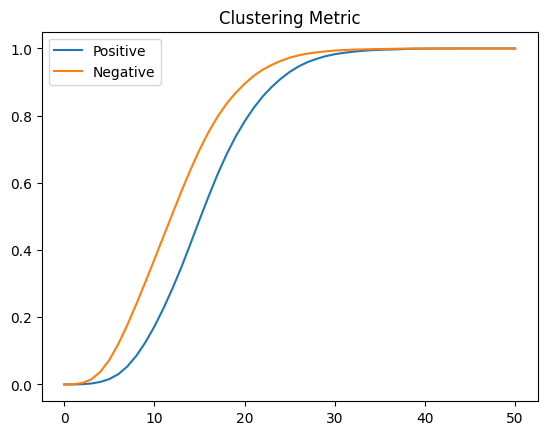

In [44]:
reid_evaluation(all_means_cir_10,all_labels_cir_10)

In [42]:
set_params(model, parameters_prox_10.tolist())
all_latents_prox_10, all_means_prox_10, all_labels_prox_10 = latent_stats(
    model, testloader, device
)

{'NN classification on test data': 34.35,
 'Positive clustering at error rate 0.1%': 1.95837947078072,
 'Positive clustering at error rate 1%': 7.999364420455731,
 'Positive clustering at error rate 10%': 30.861855792959965,
 'Trapz': 0.6308762071552436}


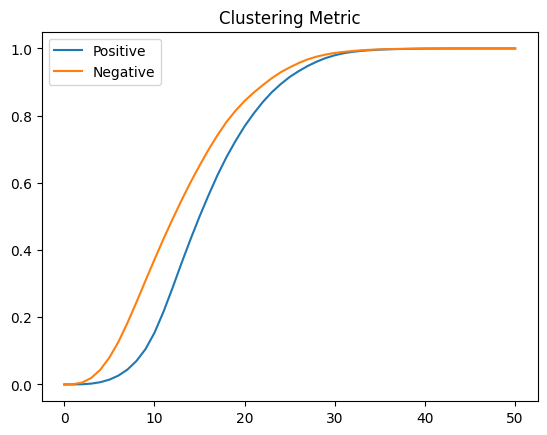

In [43]:
reid_evaluation(all_means_prox_10, all_labels_prox_10)

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    all_means_cir_10, all_labels_cir_10, test_size=0.8, random_state=42
)

# Define XGBoost parameters for multi-class classification
params = {
    "objective": "multi:softprob",  # Use softmax for multi-class problems
    "eval_metric": "mlogloss",  # Multiclass logloss metric
    "num_class": 10,  # Number of classes (change to 10 for your dataset)
    "use_label_encoder": False,  # To avoid a warning about deprecation
}

# Create DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train the XGBoost classifier
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Create DMatrix for testing
dtest = xgb.DMatrix(X_test)

# Make predictions
y_pred_probs = xgb_model.predict(dtest)

# Convert predicted probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/home/mayag88/mayag88/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:49:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 38.50%


: 

In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    all_means_prox_10, all_labels_prox_10, test_size=0.8, random_state=42
)

# Define XGBoost parameters for multi-class classification
params = {
    "objective": "multi:softprob",  # Use softmax for multi-class problems
    "eval_metric": "mlogloss",  # Multiclass logloss metric
    "num_class": 10,  # Number of classes (change to 10 for your dataset)
    "use_label_encoder": False,  # To avoid a warning about deprecation
}

# Create DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train the XGBoost classifier
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Create DMatrix for testing
dtest = xgb.DMatrix(X_test)

# Make predictions
y_pred_probs = xgb_model.predict(dtest)

# Convert predicted probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/home/mayag88/mayag88/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:49:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 35.06%


In [48]:
set_params(model, parameters_prox_0.tolist())
all_latents_prox_0, all_means_prox_0, all_labels_prox_0 = latent_stats(
    model, testloader, device
)

In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    all_means_prox_0, all_labels_prox_0, test_size=0.8, random_state=42
)

# Define XGBoost parameters for multi-class classification
params = {
    "objective": "multi:softprob",  # Use softmax for multi-class problems
    "eval_metric": "mlogloss",  # Multiclass logloss metric
    "num_class": 10,  # Number of classes (change to 10 for your dataset)
    "use_label_encoder": False,  # To avoid a warning about deprecation
}

# Create DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train the XGBoost classifier
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Create DMatrix for testing
dtest = xgb.DMatrix(X_test)

# Make predictions
y_pred_probs = xgb_model.predict(dtest)

# Convert predicted probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

NameError: name 'all_means_prox_0' is not defined

In [58]:
set_params(model, parameters_avg_10.tolist())
all_latents_avg_10, all_means_avg_10, all_labels_avg_10 = latent_stats(
    model, testloader, device)

In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    all_means_avg_10, all_labels_avg_10, test_size=0.8, random_state=42
)

# Define XGBoost parameters for multi-class classification
params = {
    "objective": "multi:softprob",  # Use softmax for multi-class problems
    "eval_metric": "mlogloss",  # Multiclass logloss metric
    "num_class": 10,  # Number of classes (change to 10 for your dataset)
    "use_label_encoder": False,  # To avoid a warning about deprecation
}

# Create DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train the XGBoost classifier
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Create DMatrix for testing
dtest = xgb.DMatrix(X_test)

# Make predictions
y_pred_probs = xgb_model.predict(dtest)

# Convert predicted probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/home/mayag88/mayag88/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:49:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 34.94%


{'NN classification on test data': 34.5,
 'Positive clustering at error rate 0.1%': 1.1390777144956825,
 'Positive clustering at error rate 1%': 5.22714520509854,
 'Positive clustering at error rate 10%': 24.612321305321487,
 'Trapz': 0.6282574340064464}


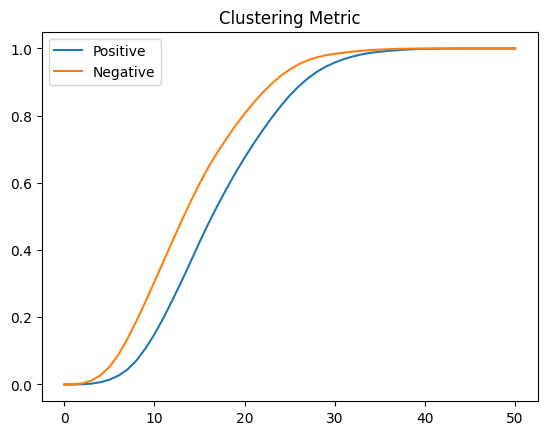

In [39]:
reid_evaluation(all_means_avg_10, all_labels_avg_10)

In [47]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    all_means_cir_reg_10, all_labels_cir_reg_10, test_size=0.8, random_state=42
)

# Define XGBoost parameters for multi-class classification
params = {
    "objective": "multi:softprob",  # Use softmax for multi-class problems
    "eval_metric": "mlogloss",  # Multiclass logloss metric
    "num_class": 10,  # Number of classes (change to 10 for your dataset)
    "use_label_encoder": False,  # To avoid a warning about deprecation
}

# Create DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train the XGBoost classifier
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Create DMatrix for testing
dtest = xgb.DMatrix(X_test)

# Make predictions
y_pred_probs = xgb_model.predict(dtest)

# Convert predicted probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/home/mayag88/mayag88/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:48:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 34.38%
